<a href="https://colab.research.google.com/github/Rizwankaka/Agentic-AI-/blob/main/Langgraph/module-4/4_4_llama_research_assistant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Research Assistant

## Review
We've covered a few major LangGraph themes:

- Memory
- Human-in-the-loop
- Controllability

Now, we'll bring these ideas together to tackle one of AI's most popular applications: research automation.

Research is often laborious work offloaded to analysts. AI has considerable potential to assist with this.

However, research demands customization: raw LLM outputs are often poorly suited for real-world decision-making workflows.

Customized, AI-based [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) workflows are a promising way to address this.

## Goal

Our goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

`Source Selection`

- Users can choose any set of input sources for their research.

`Planning`

- Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.
- `Human-in-the-loop` will be used to refine these sub-topics before research begins.

`LLM Utilization`

- Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
- The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://github.com/langchain-ai/langgraph/blob/main/examples/storm/storm.ipynb) paper.
- These interviews will be captured in a using sub-graphs with their internal state.

`Research Process`

- Experts will gather information to answer analyst questions in parallel.
- And all interviews will be conducted simultaneously through map-reduce.

`Output Format`

- The gathered insights from each interview will be synthesized into a final report.
- We'll use customizable prompts for the report, allowing for a flexible output format.

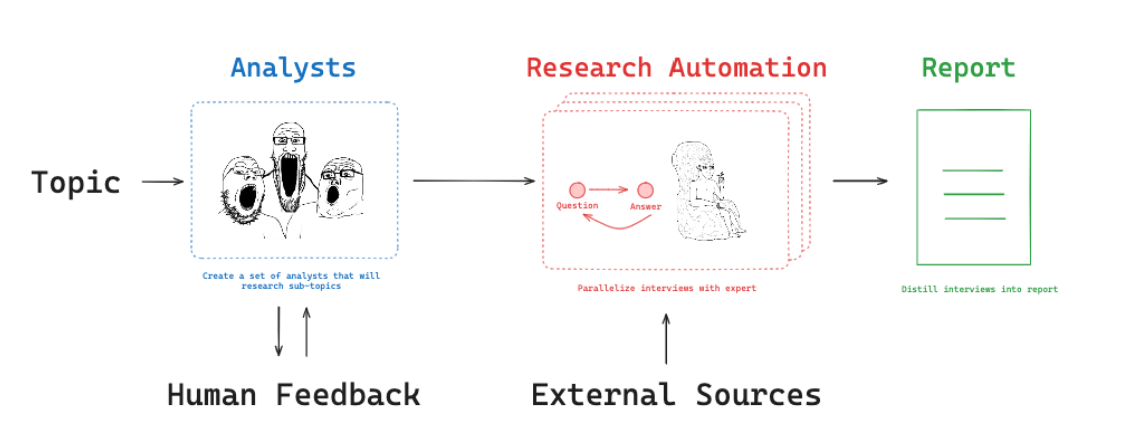

We will use llama3.2 3B to complete this project.

1. Change Runtime to T4
2. Follow Instructions to get Install llama3.1:70b
3. Now follow along the notebook

In [64]:
!pip install colab-xterm
%load_ext colabxterm
%xterm
# After terminal launch run
# Make sure to run both of these commands inside runtime Terminal
# curl -fsSL https://ollama.com/install.sh | sh
# Download and Run LLM Model
# ollama serve & ollama pull llama3.1

The colabxterm extension is already loaded. To reload it, use:
  %reload_ext colabxterm


Launching Xterm...

<IPython.core.display.Javascript object>

In [69]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_community langchain_core tavily-python wikipedia
%pip install -qU langchain-ollama

## Setup


In [70]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

We'll use [LangSmith](https:/https://docs.smith.langchain.com//) for [tracing](https://docs.smith.langchain.com/observability/concepts).

In [71]:
# # LLM
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model="llama3.1",
    temperature=0.9,
)

In [72]:
llm.invoke("Write about AI in Education under 50 words")

AIMessage(content='Artificial intelligence (AI) is transforming education by personalizing learning experiences for students. AI-powered tools analyze individual strengths and weaknesses, offering tailored recommendations and adaptive curricula. Virtual tutors and intelligent assessments enhance student engagement and achievement, making learning more effective and efficient. AI-assisted grading and feedback also save instructors time.', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2025-01-10T18:33:09.256469444Z', 'done': True, 'done_reason': 'stop', 'total_duration': 11983853323, 'load_duration': 9688851577, 'prompt_eval_count': 19, 'prompt_eval_duration': 497000000, 'eval_count': 64, 'eval_duration': 1796000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-466a8dd8-708b-4b33-b5fe-ebc8ab5b685f-0', usage_metadata={'input_tokens': 19, 'output_tokens': 64, 'total_tokens': 83})

## Generate Analysts: Human-In-The-Loop
Create analysts and review them using human-in-the-loop.

In [73]:

from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )


class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

In [74]:
# Analyst Class Explanation: https://chatgpt.com/share/66f6b849-1028-8002-9be7-67c33369bc4f
bob = Analyst(affiliation="Painting Team", name="Bob", role="Color Mixer", description="Finding the right colors")
# print(bob)
# print(type(bob))
print("---" * 20)
print(bob.persona)
# print(type(bob.persona))
print("---" * 20)

sarah = Analyst(name="Sarah", role="Designer", affiliation="Design Team", description="Making things look pretty")
# Bob and Sarah are analysts

# Perspectives is like a box that holds both Bob and Sarah
perspectives = Perspectives(analysts=[bob, sarah])
print(perspectives)
# You now have a list of all the analysts in one place

# Now we create a plan with some information
generate_state = GenerateAnalystsState(
    topic="Color Mixing",
    max_analysts=3,
    human_analyst_feedback="Make sure to choose bright colors!",
    analysts=[bob, sarah]
)
print("---" * 20)
print(generate_state)
print("---" * 20)

------------------------------------------------------------
Name: Bob
Role: Color Mixer
Affiliation: Painting Team
Description: Finding the right colors

------------------------------------------------------------
analysts=[Analyst(affiliation='Painting Team', name='Bob', role='Color Mixer', description='Finding the right colors'), Analyst(affiliation='Design Team', name='Sarah', role='Designer', description='Making things look pretty')]
------------------------------------------------------------
{'topic': 'Color Mixing', 'max_analysts': 3, 'human_analyst_feedback': 'Make sure to choose bright colors!', 'analysts': [Analyst(affiliation='Painting Team', name='Bob', role='Color Mixer', description='Finding the right colors'), Analyst(affiliation='Design Team', name='Sarah', role='Designer', description='Making things look pretty')]}
------------------------------------------------------------


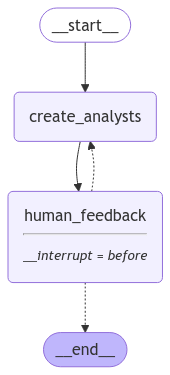

In [75]:

from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.graph.state import CompiledStateGraph
from langchain.output_parsers import PydanticOutputParser

analyst_instructions = """
You are required to create a set of AI analyst personas. Follow these steps exactly and ensure the output meets the specified format.

---

**Step-by-Step Instructions:**

1. **Review the Research Topic:**
   - Examine the following topic thoroughly:
     - {topic}
   - All analyst personas must be relevant to this topic.

2. **Analyze Editorial Feedback:**
   - Review any provided feedback, if available:
     - {human_analyst_feedback}
   - Use this feedback to shape the focus of the analyst personas. If no feedback is given, prioritize the general relevance of the topic.

3. **Identify and Select Key Themes:**
   - Analyze the topic and any feedback to extract significant themes or challenges.
   - Select the top {max_analysts} themes for which the analyst personas will be created.
   - Each theme must be distinct and represent a critical aspect of the research topic.

4. **Create Analyst Personas:**
   - For each selected theme, create one unique analyst persona that specializes in that theme.
   - The analyst personas must include the following information:
     - **Name**: A realistic name for the analyst.
     - **Role**: The analyst’s professional role, aligned with the specific theme.
     - **Affiliation**: The organization, institution, or company the analyst is associated with under 50 words.
     - **Description**: A brief but detailed description of their expertise and relevance to the chosen theme under 50 words.

---

**Output Format – Mandatory Requirements:**

- The output **must** be in valid JSON format.
- The JSON must include the following structure:
  - A key `"analysts"` with a value that is an array (list) of analyst objects.
  - Each object in the array must contain exactly four fields: `"name"`, `"role"`, `"affiliation"`, and `"description"`.
  - No extra fields or deviations from this format are allowed.

The exact output format is as follows:

```json
{{
  "analysts": [
    {{
      "name": "Analyst Name 1",
      "role": "Analyst Role 1",
      "affiliation": "Analyst Affiliation 1 under 50 words",
      "description": "Analyst Description 1 under 50 words"
    }},
    {{
      "name": "Analyst Name 2",
      "role": "Analyst Role 2",
      "affiliation": "Analyst Affiliation 2 under 50 words",
      "description": "Analyst Description 2 under 50 words"
    }},
    {{
      "name": "Analyst Name 3",
      "role": "Analyst Role 3",
      "affiliation": "Analyst Affiliation 3 under 50 words",
      "description": "Analyst Description 3 under 50 words"
    }}
  ]
}}
"""

def create_analysts(state: GenerateAnalystsState):

    """ Create analysts """

    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')

    # Enforce structured output
    # structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback,
                                                            max_analysts=max_analysts)

    # Generate question
    analysts = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])
    parsed_analysts = PydanticOutputParser(pydantic_object=Perspectives).parse(analysts.content)


    # Write the list of analysis to state
    return {"analysts": parsed_analysts.analysts}


def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"

    # Otherwise end
    return END

# Add nodes and edges
builder: StateGraph = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory: MemorySaver = MemorySaver()
graph: CompiledStateGraph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [76]:
# Input
max_analysts = 2
topic = "AI in Education"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts": max_analysts,}, thread, stream_mode="values"):
    print(event)
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

{'topic': 'AI in Education', 'max_analysts': 2}
{'topic': 'AI in Education', 'max_analysts': 2, 'analysts': [Analyst(affiliation='Develops and implements AI-powered learning systems for K-12 institutions, focusing on adaptive assessment and personalized learning experiences.', name='Dr. Rachel Kim', role='AI Research Scientist at Educational Software Company', description='Ph.D. in Computer Science, specializing in natural language processing and machine learning. Expertise in designing and deploying large-scale AI models for educational applications.'), Analyst(affiliation='Assists institutions in addressing the ethical implications of AI adoption, ensuring fairness, transparency, and accountability in AI-driven decision-making.', name='Dr. Samantha Taylor', role='Ethics Consultant at Educational Technology Firm', description='Ph.D. in Philosophy of Education, with expertise in AI ethics, data privacy, and bias mitigation. Has published numerous papers on the topic of AI in education.

In [77]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [78]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback":
                            "Add in someone from a startup to add an entrepreneur perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efcf816-9723-6a5a-8002-358e0e742419'}}

In [79]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Rachel Kim
Affiliation: Develops and implements AI-powered learning systems for K-12 institutions, focusing on adaptive assessment and personalized learning experiences.
Role: AI Research Scientist at Educational Software Company
Description: Ph.D. in Computer Science, specializing in natural language processing and machine learning. Expertise in designing and deploying large-scale AI models for educational applications.
--------------------------------------------------
Name: Dr. Samantha Taylor
Affiliation: Assists institutions in addressing the ethical implications of AI adoption, ensuring fairness, transparency, and accountability in AI-driven decision-making.
Role: Ethics Consultant at Educational Technology Firm
Description: Ph.D. in Philosophy of Education, with expertise in AI ethics, data privacy, and bias mitigation. Has published numerous papers on the topic of AI in education.
--------------------------------------------------
Name: Dr. Rachel Kim
Affiliation: Har

In [80]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback":
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efcf817-87d7-6f6b-8004-c36ea524b28d'}}

In [81]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [82]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [83]:
final_state.next

()

In [84]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50)

Name: Dr. Rachel Kim
Affiliation: Harvard University's Office of Information Technology, responsible for implementing AI solutions across various departments.
Role: AI Integration Specialist at Harvard University
Description: Expert in integrating AI tools into traditional educational settings to enhance student learning outcomes and improve administrative efficiency.
--------------------------------------------------
Name: Maya Patel
Affiliation: Stanford University, researching the application of deep learning algorithms for personalized education and intelligent tutoring systems.
Role: AI Researcher at Stanford University's AI Lab
Description: Specializes in developing cutting-edge AI solutions for education, with a focus on data-driven decision making and adaptive learning technologies.
--------------------------------------------------
Name: Ethan Thompson
Affiliation: Founder of LearnSmart Inc., a startup focused on creating innovative AI-powered educational tools for K-12 studen

## Conduct Interview
### Generate Question
The analyst will ask questions to the expert.

In [85]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [86]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. Response shall be under 80 words.

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.

2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}

Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.

When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)

    # Write messages to state
    return {"messages": [question]}

In [87]:
# prompt: # Test generate_question

# Create a sample InterviewState
sample_analyst = Analyst(name="Bob", role="Color Mixer", affiliation="Painting Team", description="Finding the right colors")
sample_state = InterviewState(max_num_turns=5, context=[], analyst=sample_analyst, interview="", sections=[], messages=[HumanMessage(content="hi")])

# Test generate_question
result = generate_question(sample_state)
print(result)

{'messages': [AIMessage(content="Hello! My name is Maya Singh, and I'm an analyst with a passion for color theory. I'm thrilled to be speaking with Bob from the Painting Team today about finding the right colors. Bob, thanks for taking the time to chat with me!\n\nCan you tell me, what's the most surprising thing you've learned about color mixing in your years of experience?", additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2025-01-10T18:34:10.53985308Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2603352292, 'load_duration': 24991436, 'prompt_eval_count': 193, 'prompt_eval_duration': 74000000, 'eval_count': 75, 'eval_duration': 2502000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-22c90b9e-01ee-46ad-9aa5-c4c8540d9582-0', usage_metadata={'input_tokens': 193, 'output_tokens': 75, 'total_tokens': 268})]}


## Generate Answer: Parallelization
The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use:

- Specific web sites e.g., via `WebBaseLoader`
- Indexed documents e.g., via [RAG](https://python.langchain.com/v0.2/docs/tutorials/rag/)
- Web search
- Wikipedia search

You can try different web search tools, like [Tavily](https://tavily.com/).

In [88]:
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

def _set_env(var: str):
    if not os.environ.get(var) or os.environ.get(var) == "{userdata.get('TAVILY_API_KEY')}":
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [89]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

In [90]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

Now, we create nodes to search the web and wikipedia.

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

In [91]:
# OpenAI LLMs are far more better and works with simpler prompts while here we had to test throughly to get json format under different situations.
search_instructions = SystemMessage(content=f"""
Return only a structured search query in the specified format below. Do not include any part of the input or the analyst's question. Avoid adding personal thoughts or asking questions. Refrain from sharing any internal thoughts or asking questions.

**Output Format:**
```json
{{
  "search_query": "your structured search query here"
}}

**Steps:**
1. Analyze the full conversation provided.
2. Focus on the final question posed by the analyst.
3. Convert this final question into a well-structured web search query.
4. You will only return json output under 100 words

**Do not This:**
- Do not ask any quetion or share anything
- Avoid adding personal thoughts or
- Do not start asking questions.
- Refrain from sharing any internal thoughts or asking questions.

**Good Example**:
    {{
          ```json
          {{
              "search_query": "best practices for integrating AI tools in education"
          }}
          ```
          ,
          {{
        "input": Return only a structured search query in the specified format below. Do not include any part of the input or the analyst's question. Avoid adding personal thoughts or asking questions. Refrain from sharing any internal thoughts or asking questions.

        **Output Format:**
        ```json
        {{
          "search_query": "your structured search query here"
        }}

        **Steps:**
        1. Analyze the full conversation provided.
        2. Focus on the final question posed by the analyst.
        3. Convert this final question into a well-structured web search query.
        4. You will only return json output under 100 words

        **Do not This:**
        - Do not ask any quetion or share anything
        - Avoid adding personal thoughts or
        - Do not start asking questions.
        - Refrain from sharing any internal thoughts or asking questions.

        **Analyst's Question:**
        "What ethical concerns should educators consider when implementing AI in classrooms?"

        **Output Format:**

        ```json
        {{
            "search_query": "ethical concerns for AI implementation in classrooms"
        }}
        ```

    }},
    }},

**BAD and Rejected Example**:
{{
  {{
    I\'d like to focus on AI in education.\n\n```json{{\n  "search_query": "AI in education"\n}}\n\n```
  }}
  {{
    Response: "Here are some insights on the impact of AI. \n\n```json{{\n  "search_query": "AI improving student engagement"\n}}\n\n```
  }}
}}

""")

In [92]:

from langchain_core.messages import get_buffer_string

def extract_first_n_words(text, n=80):
    """Helper function to extract the first n words from a text."""
    return " ".join(text.split()[:n])


def handle_parsing_error(raw_response, default_message="Failed to retrieve search results."):
    """Handle parsing error by returning the first 80 words or a default message."""
    content = getattr(raw_response, 'content', None)
    if isinstance(content, str) and content.strip():
        # Return the first 80 words of the raw response if it's a non-empty string
        return {"context": [extract_first_n_words(content)]}

    # Return a default message if content is empty or not a string
    return {"context": [default_message]}




def search_web(state: InterviewState):
    """Retrieve docs from web search."""

    print("\n\nsearch_web_state\n\n", state)
    raw_response = llm.invoke([search_instructions] + state['messages'])
    print("\n\nsearch_web_raw_response\n\n", raw_response)

    # If content is empty or None
    if not raw_response.content or raw_response.content == '':
        return {"context": [state.get("topic", "No topic found")]}

    try:
        # Try to parse the raw response
        search_query = PydanticOutputParser(pydantic_object=SearchQuery).parse(raw_response.content)
        print("\n\nsearch_web_parsed\n\n", search_query)

        # Perform the search
        search_docs = tavily_search.invoke(search_query.search_query)

        # Format the search results
        formatted_search_docs = "\n\n---\n\n".join(
            [
                f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
                for doc in search_docs
            ]
        )

        return {"context": [formatted_search_docs]}

    except Exception as e:
        print(f"Error while parsing or fetching docs: {e}")
        # Handle the error and return the first 80 words or a default message
        return handle_parsing_error(raw_response, default_message=state.get("topic", "No topic found"))


def search_wikipedia(state: InterviewState):
    """Retrieve docs from Wikipedia."""
    print("\n\nsearch_wikipedia_state\n\n", state)

    raw_response = llm.invoke([search_instructions] + state['messages'])
    print("\n\nsearch_wikipedia_raw_response\n\n", raw_response)

    # If content is empty or None
    if not raw_response.content or raw_response.content == '':
        return {"context": [state.get("topic", "No topic found")]}

    try:
        # Try to parse the raw response
        search_query = PydanticOutputParser(pydantic_object=SearchQuery).parse(raw_response.content)
        print("\n\nsearch_wikipedia_parsed\n\n", search_query)

        # Perform the search
        search_docs = WikipediaLoader(query=search_query.search_query, load_max_docs=2).load()

        # Format the search results
        formatted_search_docs = "\n\n---\n\n".join(
            [
                f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
                for doc in search_docs
            ]
        )

        return {"context": [formatted_search_docs]}

    except Exception as e:
        print(f"Error while parsing or fetching docs: {e}")
        # Handle the error and return the first 80 words or a default message
        return handle_parsing_error(raw_response, default_message=state.get("topic", "No topic found"))

In [93]:
# Testing out Prompt Results
sample_state_for_search = InterviewState(
    messages=[HumanMessage(content='Is this AI in Education good domain for research?', id='e79930a6-9da3-4731-bf01-a5017674f5bb'),
        AIMessage(content="I'm Maya Ramos, a researcher in Educational Research. ",)]
)

result_search_web = search_web(sample_state_for_search)
print(result_search_web)

result_search_wikipedia= search_wikipedia(sample_state_for_search)
print(result_search_wikipedia)



search_web_state

 {'messages': [HumanMessage(content='Is this AI in Education good domain for research?', additional_kwargs={}, response_metadata={}, id='e79930a6-9da3-4731-bf01-a5017674f5bb'), AIMessage(content="I'm Maya Ramos, a researcher in Educational Research. ", additional_kwargs={}, response_metadata={})]}


search_web_raw_response

 content=' I have worked with numerous studies focusing on the positive impact of artificial intelligence (AI) tools to improve learning outcomes.\n\nIn my opinion, yes, AI in education is an excellent domain for research. The integration of technology and its potential to personalize learning experiences makes it a field ripe for exploration. There are various avenues you could explore within this domain.\n\nSome subtopics worth investigating include: \n1. Accessibility - How can AI improve accessibility for students with disabilities?\n2. Personalization - Can AI be used to tailor lessons based on individual student\'s strengths and weaknesses?

In [94]:

answer_instructions = """
You are an expert being interviewed by an analyst. Your response must strictly adhere to the following instructions and be under 250 words.

---

**Analyst Focus:**
- The analyst’s area of focus is: {goals}.

**Context for Your Answer:**
- Use the information provided in this context only:
  - {context}
- Your answer must be based solely on the details from this context.

---

**Guidelines for Answering:**

1. **Use Only Provided Information:**
   - Do not add any external information or make assumptions beyond what is explicitly mentioned in the context.

2. **Source Citations:**
   - The context includes sources at the beginning of each individual document.
   - For every statement based on the provided context, cite the relevant source directly after the statement in brackets. Example: `[1]`.

3. **Citation Format:**
   - At the end of your answer, list the sources in the order they appear:
     - Use the format: `[1] Source Name, [2] Source Name`.
   - For example, if the source is listed as `<Document source="assistant/docs/llama3_1.pdf" page="7"/>`, your citation should appear as:
     - `[1] assistant/docs/llama3_1.pdf, page 7`
   - **Do not include** the "Document source" preamble or add extra brackets to the citation.

---

**Important Notes:**

- Ensure all citations appear correctly in both in-text references and at the end of the answer.
- If no sources apply to a part of your answer, omit any citations for that part.
- Your entire response must follow this structure and format exactly.
"""


def generate_answer(state: InterviewState):

    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]
    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)

    # Name the message as coming from the expert
    answer.name = "expert"

    # Append it to state
    return {"messages": [answer]}

In [95]:

def save_interview(state: InterviewState):

    """ Save interviews """

    # Get messages
    messages = state["messages"]

    # Convert interview to a string
    interview = get_buffer_string(messages)

    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState,
                   name: str = "expert"):

    """ Route between question and answer """

    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    print("\n\nnum_responses\n\n", num_responses)

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    # Check if the text includes "Thank you so much for your help!" and in start we may have Alex: etc.

    if "thank you so much for your help!" in last_question.content.lower():
        return 'save_interview'
    return "ask_question"

In [96]:
section_writer_instructions = """
You are an expert technical writer. Your task is to create a concise, easily digestible section of a report based on a set of source documents under 1000 words. Follow the instructions carefully to ensure the report is well-structured and accurate.

---

### Instructions:

1. **Analyze the Source Documents:**
   - Each document is labeled at the start with a `<Document>` tag. Use this information to identify and refer to the sources.

2. **Report Structure:**
   - Format the report using **Markdown**:
     - Use `##` for the section title.
     - Use `###` for sub-section headers.

3. **Report Format:**
   - Follow this structure when writing the report:
     - **Title** (`##` header): Make this engaging and relevant to the analyst's focus area: {focus}.
     - **Summary** (`###` header): Provide a concise overview based on the content of the source documents:
       - Begin with background/context related to the analyst’s focus area.
       - Highlight any novel, surprising, or insightful points from the interview.
       - Create a **numbered list** of sources as you reference them in the summary (e.g., [1], [2]).
     - **Sources** (`###` header): List all sources you referenced in the report.

4. **Writing the Summary:**
   - Set up the summary by introducing the general context or background related to the analyst’s focus.
   - Focus on **novel insights**, emphasizing what’s new, interesting, or unexpected.
   - Keep the summary to **400 words or fewer**.
   - **Do not mention** the names of interviewers or experts in the summary.
   - Use in-text citations, numbered according to the sources (e.g., [1], [2]).

5. **Sources Section:**
   - List all sources you used in the report under the **Sources** section.
   - Provide full links to online sources or specific document paths, ensuring each source is accurate and accessible.
   - Separate each source by a **newline** using two spaces at the end of each line in Markdown.
     - Example:
       ```markdown
       ### Sources
       [1] https://example.com/document1
       [2] assistant/docs/document2.pdf
       ```
   - **Do not list redundant sources**. For instance, if two references lead to the same document, only list it once.

6. **Final Review:**
   - Ensure that your report follows this exact structure.
   - There should be **no preamble** before the title.
   - Verify all formatting, citations, and guidelines have been followed.

---

### Key Points:
- **Engage with the focus area**: Ensure the title and summary are closely aligned with the analyst’s objectives.
- **Keep it concise**: Aim for clarity and brevity, keeping the word count under 400.
- **Accurate citations**: Use sources appropriately and ensure no duplicates in the list.
"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]

    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")])

    # Append it to state
    return {"sections": [section.content]}

Add nodes and edges

In [97]:
#Add nodes and edges
interview_builder: StateGraph = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview
memory: MemorySaver = MemorySaver()
interview_graph: CompiledStateGraph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

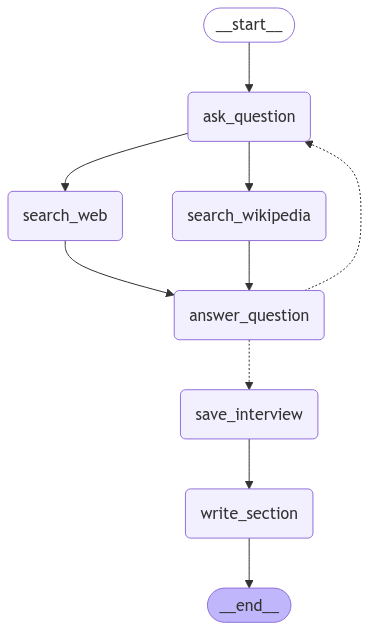

In [98]:
# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [99]:
# Pick one analyst
analysts[0]

Analyst(affiliation="Harvard University's Office of Information Technology, responsible for implementing AI solutions across various departments.", name='Dr. Rachel Kim', role='AI Integration Specialist at Harvard University', description='Expert in integrating AI tools into traditional educational settings to enhance student learning outcomes and improve administrative efficiency.')

In [100]:
topic

'AI in Education'

Here, we run the interview passing an index of the llama3.1 paper, which is related to our topic.

In [101]:
from IPython.display import Markdown
messages = [HumanMessage(f"We are thinking about {topic}?")]
thread = {"configurable": {"thread_id": "1"}}

In [102]:
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 3}, thread)
Markdown(interview['sections'][0])



search_web_state

 {'messages': [HumanMessage(content='We are thinking about AI in Education?', additional_kwargs={}, response_metadata={}, id='d3b83c3b-cb5b-4a7f-a55f-34f694b8eae9'), AIMessage(content="Hi Dr. Kim, I'm Maya Chen, a research analyst from the Harvard University's Institute for Educational Technology. We're interested in exploring innovative ways to integrate AI into traditional educational settings. Can you share with me some of the most interesting and effective applications of AI that you've seen so far?", additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2025-01-10T18:34:38.452704331Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2262750149, 'load_duration': 42576983, 'prompt_eval_count': 235, 'prompt_eval_duration': 94000000, 'eval_count': 61, 'eval_duration': 2123000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-2d83a59e-f174-47de-85fe-c48b6f63dca0-0', usage_metadata={'input_token

## Integrating AI in Indian Education: Success Stories, Challenges, and Opportunities

### Summary

The integration of Artificial Intelligence (AI) in education has been transformative globally, with the potential to enhance teaching and learning experiences. In India, educational institutions are leveraging AI-powered tools and platforms to improve student outcomes. However, challenges such as data privacy and bias must be addressed to ensure responsible AI adoption.

Notable success stories include the use of AI in Loyola University's administrative systems, which provided real-time answers to student inquiries and relieved staff strain [1]. Another example is the deployment of generative AI tools at Harvard University, which enable faculty to create personalized learning experiences for students [2].

These advancements raise important ethical considerations, including the need for educators to balance technology with human interaction. Nevertheless, AI's potential in education is vast, from intelligent tutoring systems to real-time feedback generation.

### Recommendations

To effectively leverage AI in education, stakeholders should:

1. Implement AI-powered tools that align with each learner's unique profile.
2. Ensure data privacy and security when using AI-driven platforms.
3. Provide educators with training on responsible AI use.
4. Encourage collaboration between technology developers and educational institutions to address specific needs.

### Sources

[1] https://www.vktr.com/ai-disruption/5-ai-case-studies-in-education/
[2] https://scholar.harvard.edu/sites/scholar.harvard.edu/files/roychan/files/ebook_chatgpt_and_global_higher_education-26-42.pdf
https://teachflow.ai/ai-in-education-global-success-stories-unveiled/
https://www.gse.harvard.edu/ideas/usable-knowledge/23/11/better-feedback-ai
https://www.harvard.edu/ai/teaching-resources/
Note: The sources listed above are a selection of the documents provided, and additional resources may be relevant to the topic.

In [103]:
len(interview['sections'])

1

## Parallelze interviews: Map-Reduce
We parallelize the interviews via the Send() API, a map step.

We combine them into the report body in a reduce step.

## Finalize
We add a final step to write an intro and conclusion to the final report.

In [104]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

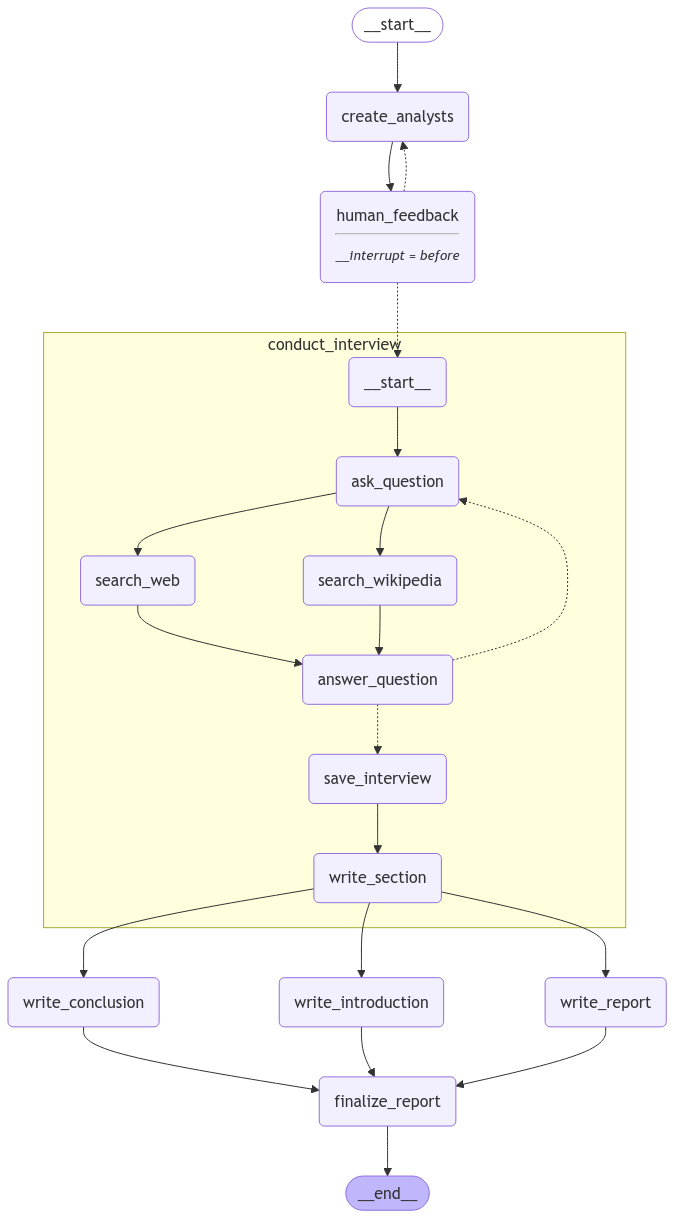

In [105]:

from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

report_writer_instructions = """You are a technical writer creating a report on this overall topic:

{topic}

You have a team of analysts. Each analyst has done two things:

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task:

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos.
4. Summarize the central points in each memo into a cohesive single narrative.

To format your scientific report:

1. Use markdown formatting.
2. Include no pre-amble for the report.
3. Use no sub-heading.
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from:

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")])
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting.

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header.

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report

    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")])
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report

    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")])
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges
builder: StateGraph = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory: MemorySaver = MemorySaver()
graph: CompiledStateGraph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Let's ask an open-ended question about LangGraph.

In [106]:
# Inputs
max_analysts = 7
topic = "Impact of AI in education industry"
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts,
                           },
                          thread,
                          stream_mode="values"):

    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Emily Wilson
Affiliation: Springfield Public Schools; leading the district's digital transformation initiative.
Role: Director of Educational Technology
Description: Expert in AI adoption strategies, focusing on integrating cutting-edge tools into traditional curricula. Skilled in project management and team leadership.
--------------------------------------------------
Name: David Lee
Affiliation: EdTechPro; developing training programs for educators to effectively utilize AI.
Role: AI Training Specialist
Description: Specialist in teacher training and support, with a focus on preparing educators for the integration of AI. Expertise in instructional design and pedagogy.
--------------------------------------------------
Name: Sarah Taylor
Affiliation: Seattle Public Schools; overseeing efforts to bridge the digital divide.
Role: Digital Equity Coordinator
Description: Focused on mitigating the digital divide, particularly in underserved communities. Skilled in community outreach

In [107]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback":
                                "Add in the CEO of MetaAI"}, as_node="human_feedback")

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1efcf81b-4dcd-6c56-8002-9f9eb31a63ca'}}

In [108]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Emily Wilson
Affiliation: Springfield Public Schools; leading the district's digital transformation initiative.
Role: Director of Educational Technology
Description: Expert in AI adoption strategies, focusing on integrating cutting-edge tools into traditional curricula. Skilled in project management and team leadership.
--------------------------------------------------
Name: David Lee
Affiliation: EdTechPro; developing training programs for educators to effectively utilize AI.
Role: AI Training Specialist
Description: Specialist in teacher training and support, with a focus on preparing educators for the integration of AI. Expertise in instructional design and pedagogy.
--------------------------------------------------
Name: Sarah Taylor
Affiliation: Seattle Public Schools; overseeing efforts to bridge the digital divide.
Role: Digital Equity Coordinator
Description: Focused on mitigating the digital divide, particularly in underserved communities. Skilled in community outreach

In [109]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback":
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1efcf81c-1448-6c7e-8004-c6b50b13a27f'}}

In [110]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("\n\n--event--\n\n", event)
    node_name = next(iter(event.keys()))
    print(node_name)



search_web_state

 {'messages': [HumanMessage(content='So you said you were writing an article on Impact of AI in education industry?', additional_kwargs={}, response_metadata={}, id='571732fc-29e1-4954-937e-62e63825d8da'), AIMessage(content="Hi Ava, nice to meet you! I'm Sophia Patel, a data analyst focusing on emerging tech trends in education. Can you share with me some surprising ways AI can perpetuate biases in educational tools and what MetaAI Research Team is doing to mitigate these effects?", additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2025-01-10T18:36:11.845666128Z', 'done': True, 'done_reason': 'stop', 'total_duration': 4592294480, 'load_duration': 168607060, 'prompt_eval_count': 234, 'prompt_eval_duration': 1005000000, 'eval_count': 54, 'eval_duration': 3403000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-1a5affbf-628e-48fb-bb10-9edfe9c7b4f1-0', usage_metadata={'input_tokens': 234, 'output_tok

In [111]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

Here is a potential introduction for a report:

**Introduction**

This report provides an overview of [briefly mention the purpose and scope of the report, including any relevant context or background information]. The primary objective of this report is to [clearly state the main goal or objective of the report]. Through a comprehensive analysis of [mention key areas of focus, such as data collection, research methodology, or case studies], this report aims to [present findings, provide insights, or make recommendations] that will inform and support [stakeholders, decision-makers, or other relevant parties].

The following pages will present the results of our investigation, including [briefly mention any key findings or conclusions]. We hope that this report will contribute to a better understanding of [topic or issue], and provide valuable insights for those seeking to address the challenges and opportunities associated with it.

[Insert any necessary acknowledgments, dedications, or other introductory information as needed.]

This is just one example introduction, but you can customize it to fit your specific needs and report requirements.

---

I don't see any memos provided. Please share the memos, and I'll be happy to write a comprehensive report based on the information they contain.

---

However, I don't have any information on a specific report. Could you please provide more context or details about the report you'd like me to conclude? This will help me assist you better.

That being said, here are some general guidelines for writing a conclusion:

**Concluding a Report**

A conclusion is a summary of the main findings and recommendations from your research. It's an opportunity to reinforce your key points, reiterate your thesis statement (if applicable), and leave a lasting impression on your readers.

Here's an example structure for a report conclusion:

1. **Restate the purpose**: Briefly restate the objective or problem that was being addressed in the report.
2. **Highlight the main findings**: Recap the key results, data, or observations from the research.
3. **Interpret and discuss implications**: Explain what the findings mean and how they relate to the broader context.
4. **Recommend actions**: Outline practical recommendations based on the analysis and insights gained.
5. **Provide a final thought or call-to-action**: Leave readers with a lasting impression, such as an idea for future research or a suggestion for implementation.

Here's a sample conclusion:

**Sample Conclusion**

In conclusion, our investigation into [Topic] revealed significant results that underscore the importance of [Key Finding]. Our analysis suggests that [Interpretation and Discussion], which has implications for [Broader Context].

Based on these findings, we recommend that [Recommendations]. To achieve success in this area, organizations should prioritize [Actionable Steps].